## Data observe

In [117]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook

In [3]:
data = pd.read_csv('~/data/milestone2/train.csv')

In [9]:
data = data.drop(['ele_P'], axis=1)

data['index'] = data['index'].astype(np.int32)

data['TX'] = data['TX'].astype(np.float32)
data['TY'] = data['TY'].astype(np.float32)

data['X'] = data['X'].astype(np.float32)
data['Y'] = data['Y'].astype(np.float32)
data['Z'] = data['Z'].astype(np.float32)

data['chi2'] = data['chi2'].astype(np.float32)
data['data_ind'] = data['data_ind'].astype(np.int32)
data['signal'] = data['signal'].astype(np.bool)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7503968 entries, 0 to 7503967
Data columns (total 9 columns):
index       int32
TX          float32
TY          float32
X           float32
Y           float32
Z           float32
chi2        float32
data_ind    int32
signal      bool
dtypes: bool(1), float32(6), int32(2)
memory usage: 236.2 MB


In [11]:
data.head()

,index,TX,TY,X,Y,Z,chi2,data_ind,signal
0,0,0.013209,0.067202,66081.937500,52968.695312,11637.0,0.880506,0,True
1,1,0.014165,0.071018,66100.265625,53058.140625,12930.0,0.522405,0,True
2,2,0.017983,0.069956,66118.492188,53147.492188,14223.0,0.971824,0,True
3,3,0.013956,-0.058355,66121.281250,53082.601562,14223.0,0.771712,0,True
4,4,0.002209,0.045891,66116.429688,53143.609375,14223.0,0.345887,0,True


In [49]:
def drow_brick(data, signal=None):
    plt.figure(figsize=(16, 4))
    for i, axis in zip([1, 2], ['X','Y']):
        plt.subplot(1, 2, i)
        if (signal):
            plt.scatter(data[data.signal == signal].Z, data[data.signal == signal][axis])
        else:
            plt.scatter(data.Z, data[axis])

        plt.title('EM shower')
        plt.xlabel('Z')
        plt.ylabel(axis)

    plt.show()

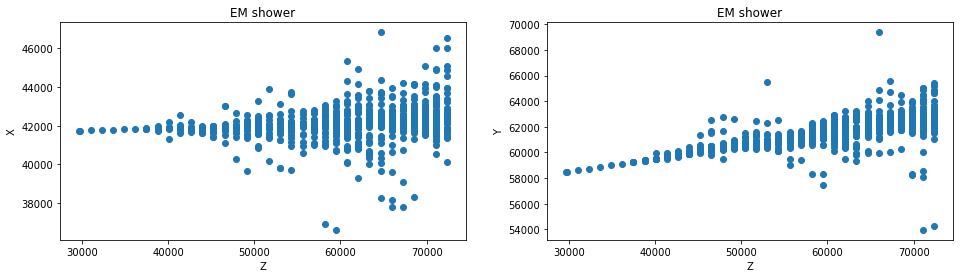

In [50]:
drow_brick(data[data.data_ind == 7], signal=True)

In [86]:
def draw_tan(data):
    plt.figure(figsize=(14, 4))
    
    for i, axis in zip([1, 2], ['TX','TY']):
        plt.subplot(1, 2, i)
        plt.hist(data[data.signal == True]['TY'].dropna(), bins=50, histtype="step", normed=True)
        plt.hist(data[data.signal == False]['TY'].dropna(), bins=50, histtype="step", normed=True)
        plt.title(axis + ' hist')
        plt.legend(['signal','background'])

    plt.show()

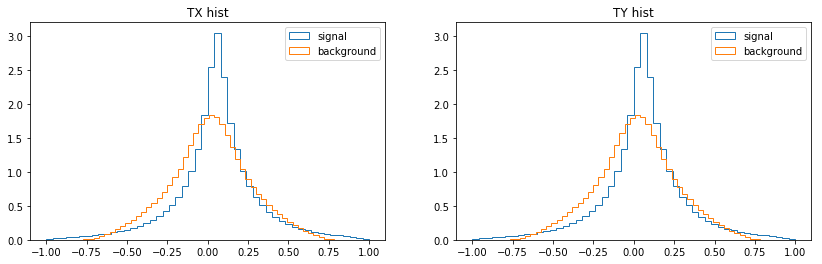

In [88]:
draw_tan(data)

In [103]:
def draw_axes(data):
    plt.figure(figsize=(18, 4))
    
    for i, axis in zip([1, 2, 3], ['X','Y','Z']):
        plt.subplot(1, 3, i)
        plt.hist(data[data.signal == True][axis], bins=58, histtype="step", normed=True)
        plt.hist(data[data.signal == False][axis], bins=58, histtype="step", normed=True)
        plt.title(axis + ' hist')
        plt.legend(['signal','background'])

    plt.show()

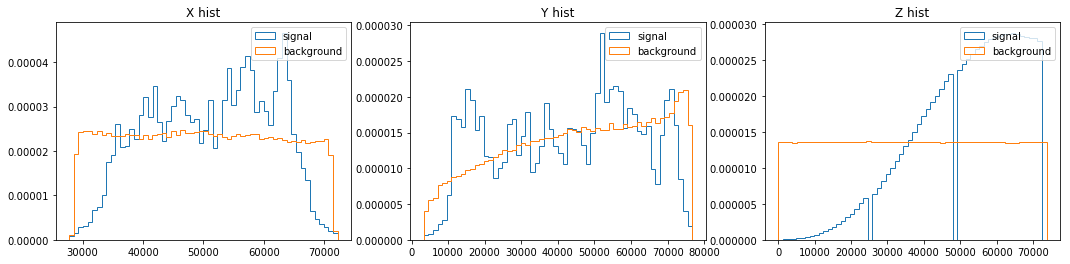

In [104]:
draw_axes(data)

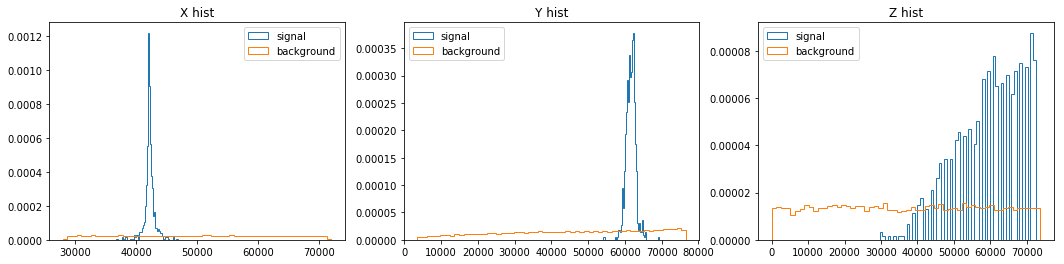

In [95]:
draw_axes(data[data.data_ind == 7])

In [99]:
def draw_chi2(data):
    plt.hist(data[data.signal == True].chi2.dropna(), bins=50, histtype="step", normed=True)
    plt.hist(data[data.signal == False].chi2.dropna(), bins=50, histtype="step", normed=True)
    plt.title('chi2 hist')
    plt.legend(['signal','background'])
    plt.show()

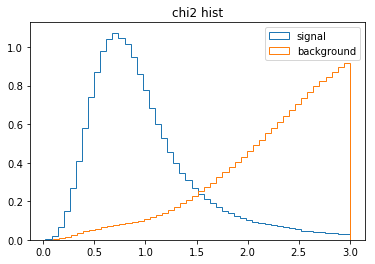

In [100]:
draw_chi2(data)

## New features

In [191]:
def dmin(v, vl):
    return np.min(np.sum((v.values - vl)**2, axis=1))
def ddmin_f(efr, df):
    z0 = efr.iloc[0]['Z']
    if z0 == zmax:
        efr['dfore'] = (np.float32)(1e6)
    else:
        eto = df.query("Z=={}".format(z0 + dz))
        gfr = efr[["X1", "Y1", "X2", "Y2"]]
        gto = eto[["X", "Y", "X1", "Y1"]]
        d = gfr.apply(dmin, axis=1, args=(gto.values,))
        efr['dfore'] = d.astype(np.float32)
    return efr
def ddmin_b(eto, df):
    z0 = eto.iloc[0]['Z']
    if z0 == zmin:
        eto['dback'] = (np.float32)(1e6)
    else:
        efr = df.query("Z=={}".format(z0 - dz))
        gfr = efr[["X1", "Y1", "X2", "Y2"]]
        gto = eto[["X", "Y", "X1", "Y1"]]
        d = gto.apply(dmin, axis=1, args=(gfr.values,))
        eto['dback'] = d.astype(np.float32)
    return eto
def ddmin(ev, df):
    return ddmin_b(ddmin_f(ev, df), df)
def features(df):
    dx = df['TX'] * dz
    dy = df['TY'] * dz
    df['X1'] = df['X'] + dx
    df['Y1'] = df['Y'] + dy
    df['X2'] = df['X1'] + dx
    df['Y2'] = df['Y1'] + dy
    return df.groupby("Z").apply(ddmin, df)

In [188]:
zl = np.unique(brick['Z'])
zmin = np.min(zl)
zmax = np.max(zl)
dz = np.diff(zl)[0]
print('zmin = {}'.format(zmin))
print('zmax = {}'.format(zmax))
print('len(zl) = {}'.format(len(zl)))
print('dz = {}'.format(dz))

zmin = 0.0
zmax = 73701.0
len(zl) = 58
dz = 1293.0


In [177]:
data = data[data.Z % 1293 == 0]

In [196]:
brick = data[data.data_ind == 0]
data_extended = features(brick)

for i in tqdm_notebook(range(1,100)):
    brick = data[data.data_ind == i]
    brick = features(brick)
    data_extended = pd.concat([data_extended, brick])

/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/in

In [210]:
dz2 = dz*2
def dmin(v, vl):
    return np.min(np.sum((v.values - vl)**2, axis=1))
def ddmin_f(efr, df):
    z0 = efr.iloc[0]['Z']
    if (z0 == zmax) or (z0 == (zmax - 1293)):
        efr['dfore2'] = (np.float32)(1e6)
    else:
        eto = df.query("Z=={}".format(z0 + dz2))
        gfr = efr[["X2", "Y2", "X3", "Y3"]]
        gto = eto[["X", "Y", "X1", "Y1"]]
        d = gfr.apply(dmin, axis=1, args=(gto.values,))
        efr['dfore2'] = d.astype(np.float32)
    return efr
def ddmin_b(eto, df):
    z0 = eto.iloc[0]['Z']
    if (z0 == zmin) or (z0 == (zmin + 1293)):
        eto['dback2'] = (np.float32)(1e6)
    else:
        efr = df.query("Z=={}".format(z0 - dz2))
        gfr = efr[["X2", "Y2", "X3", "Y3"]]
        gto = eto[["X", "Y", "X1", "Y1"]]
        d = gto.apply(dmin, axis=1, args=(gfr.values,))
        eto['dback2'] = d.astype(np.float32)
    return eto
def ddmin(ev, df):
    return ddmin_b(ddmin_f(ev, df), df)
def features_2_layer(df):
    dx = df['TX'] * dz
    dy = df['TY'] * dz
    #df['X1'] = df['X'] + dx
    #df['Y1'] = df['Y'] + dy
    #df['X2'] = df['X1'] + dx
    #df['Y2'] = df['Y1'] + dy
    
    df['X3'] = df['X2'] + dx
    df['Y3'] = df['Y2'] + dy
    
    return df.groupby("Z").apply(ddmin, df)


brick = data_extended[data_extended.data_ind == 0]
data_extended2 = features_2_layer(brick)

for i in tqdm_notebook(range(1,100)):
    brick = data_extended[data_extended.data_ind == i]
    brick = features_2_layer(brick)
    data_extended2 = pd.concat([data_extended2, brick])

/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [212]:
def dmin(v, vl):
    return np.min(np.sum((v.values - vl)**2, axis=1))
def ddmin_f(efr, df):
    z0 = efr.iloc[0]['Z']
    if (z0 == zmax):
        efr['dfore_simp'] = (np.float32)(1e6)
    else:
        eto = df.query("Z=={}".format(z0 + dz))
        gfr = efr[["X1", "Y1"]]
        gto = eto[["X", "Y"]]
        d = gfr.apply(dmin, axis=1, args=(gto.values,))
        efr['dfore_simp'] = d.astype(np.float32)
    return efr
def ddmin_b(eto, df):
    z0 = eto.iloc[0]['Z']
    if (z0 == zmin):
        eto['dback_simp'] = (np.float32)(1e6)
    else:
        efr = df.query("Z=={}".format(z0 - dz))
        gfr = efr[["X1", "Y1"]]
        gto = eto[["X", "Y"]]
        d = gto.apply(dmin, axis=1, args=(gfr.values,))
        eto['dback_simp'] = d.astype(np.float32)
    return eto
def ddmin(ev, df):
    return ddmin_b(ddmin_f(ev, df), df)
def features_simp(df):
    return df.groupby("Z").apply(ddmin, df)


brick = data_extended2[data_extended2.data_ind == 0]
data_extended3 = features_simp(brick)

for i in tqdm_notebook(range(1,100)):
    brick = data_extended2[data_extended2.data_ind == i]
    brick = features_simp(brick)
    data_extended3 = pd.concat([data_extended3, brick])

In [213]:
data_extended3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1504417 entries, 0 to 2039567
Data columns (total 21 columns):
index         1504417 non-null int32
TX            1504417 non-null float32
TY            1504417 non-null float32
X             1504417 non-null float32
Y             1504417 non-null float32
Z             1504417 non-null float32
chi2          1504417 non-null float32
data_ind      1504417 non-null int32
signal        1504417 non-null bool
X1            1504417 non-null float32
Y1            1504417 non-null float32
X2            1504417 non-null float32
Y2            1504417 non-null float32
dfore         1504417 non-null float32
dback         1504417 non-null float32
X3            1504417 non-null float32
Y3            1504417 non-null float32
dfore2        1504417 non-null float32
dback2        1504417 non-null float32
dfore_simp    1504417 non-null float32
dback_simp    1504417 non-null float32
dtypes: bool(1), float32(18), int32(2)
memory usage: 127.7 MB


In [214]:
data_extended3.head()

,index,TX,TY,X,Y,Z,chi2,data_ind,signal,X1,...,X2,Y2,dfore,dback,X3,Y3,dfore2,dback2,dfore_simp,dback_simp
0,0,0.013209,0.067202,66081.937500,52968.695312,11637.0,0.880506,0,True,66099.015625,...,66116.093750,53142.484375,70.256973,1.915982e+07,66133.171875,53229.378906,177.664261,2.891000e+06,8.068985,1.072171e+07
1,1,0.014165,0.071018,66100.265625,53058.140625,12930.0,0.522405,0,True,66118.578125,...,66136.890625,53241.796875,44.512939,7.025697e+01,66155.203125,53333.625000,55.864685,1.543606e+07,6.140747,8.068985e+00
2,2,0.017983,0.069956,66118.492188,53147.492188,14223.0,0.971824,0,True,66141.742188,...,66164.992188,53328.398438,183.387268,4.451294e+01,66188.242188,53418.851562,552.480896,1.776643e+02,28.555908,6.140747e+00
3,3,0.013956,-0.058355,66121.281250,53082.601562,14223.0,0.771712,0,True,66139.328125,...,66157.375000,52931.695312,5990.734375,5.961148e+04,66175.421875,52856.242188,37861.121094,5.303714e+04,207.869263,4.545645e+03
4,4,0.002209,0.045891,66116.429688,53143.609375,14223.0,0.345887,0,True,66119.289062,...,66122.148438,53262.281250,278.122070,1.864316e+03,66125.007812,53321.617188,6056.386719,8.928458e+02,15.965820,4.505743e+01


## CatBoost

In [105]:
from catboost import CatBoostClassifier

/opt/conda/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module '_catboost' does not match runtime version 3.6
  return f(*args, **kwds)


In [219]:
data_ind_train = [x for x in range(50)]

In [220]:
X_train = data_extended3[data_extended3.data_ind == data_ind_train[0]].drop(['data_ind', 'signal','index'], axis=1)
y_train = data_extended3[data_extended3.data_ind == data_ind_train[0]].signal

for i in tqdm_notebook(range(len(data_ind_train))):
    X_train = pd.concat([X_train, \
                         data_extended3[data_extended3.data_ind == data_ind_train[i]].drop(['data_ind', 'signal','index'], axis=1)], copy=False)
    y_train = pd.concat([y_train, data_extended3[data_extended3.data_ind == data_ind_train[i]].signal], copy=False)

In [257]:
model = CatBoostClassifier(iterations=500, depth=10, learning_rate=1,
                           loss_function='CrossEntropy', logging_level='Verbose', random_seed=42, verbose=True)

#%time model.fit(X_train.values, y_train)
%time model.fit(data_extended3.drop(['data_ind', 'signal','index'], axis=1).values, data_extended3.signal)

Borders generated
0:	learn 0.4798472233passed: 0.75 sec	total: 1m 40s	remaining: 13h 53m
1:	learn 0.3561892183passed: 0.634 sec	total: 1m 40s	remaining: 6h 58m 18s
2:	learn 0.2798878855passed: 0.571 sec	total: 1m 41s	remaining: 4h 39m 53s
3:	learn 0.229626105passed: 0.584 sec	total: 1m 41s	remaining: 3h 30m 42s
4:	learn 0.194483838passed: 0.561 sec	total: 1m 42s	remaining: 2h 49m 9s
5:	learn 0.1688265799passed: 0.644 sec	total: 1m 43s	remaining: 2h 21m 33s
6:	learn 0.1490852194passed: 0.605 sec	total: 1m 43s	remaining: 2h 1m 48s
7:	learn 0.1337140699passed: 0.658 sec	total: 1m 44s	remaining: 1h 47m 2s
8:	learn 0.121391468passed: 0.618 sec	total: 1m 45s	remaining: 1h 35m 30s
9:	learn 0.1113030057passed: 0.586 sec	total: 1m 45s	remaining: 1h 26m 15s
10:	learn 0.102813579passed: 0.582 sec	total: 1m 46s	remaining: 1h 18m 41s
11:	learn 0.09570394652passed: 0.577 sec	total: 1m 46s	remaining: 1h 12m 22s
12:	learn 0.089613064passed: 0.583 sec	total: 1m 47s	remaining: 1h 7m 2s
13:	learn 0.08432

112:	learn 0.0219358588passed: 0.595 sec	total: 2m 47s	remaining: 9m 33s
113:	learn 0.02185859945passed: 0.561 sec	total: 2m 47s	remaining: 9m 28s
114:	learn 0.02177823846passed: 0.552 sec	total: 2m 48s	remaining: 9m 24s
115:	learn 0.02169868207passed: 0.57 sec	total: 2m 49s	remaining: 9m 19s
116:	learn 0.0216190267passed: 0.637 sec	total: 2m 49s	remaining: 9m 15s
117:	learn 0.02154761658passed: 0.659 sec	total: 2m 50s	remaining: 9m 11s
118:	learn 0.02147415314passed: 0.6 sec	total: 2m 50s	remaining: 9m 7s
119:	learn 0.02139879179passed: 0.599 sec	total: 2m 51s	remaining: 9m 3s
120:	learn 0.02132687931passed: 0.613 sec	total: 2m 52s	remaining: 8m 59s
121:	learn 0.0212552858passed: 0.572 sec	total: 2m 52s	remaining: 8m 55s
122:	learn 0.02118406116passed: 0.575 sec	total: 2m 53s	remaining: 8m 51s
123:	learn 0.02111165319passed: 0.555 sec	total: 2m 53s	remaining: 8m 47s
124:	learn 0.02104649743passed: 0.58 sec	total: 2m 54s	remaining: 8m 43s
125:	learn 0.02098290748passed: 0.542 sec	total

224:	learn 0.01719490341passed: 0.725 sec	total: 3m 54s	remaining: 4m 46s
225:	learn 0.01717311115passed: 0.611 sec	total: 3m 54s	remaining: 4m 44s
226:	learn 0.01715046358passed: 0.619 sec	total: 3m 55s	remaining: 4m 43s
227:	learn 0.01712575237passed: 0.6 sec	total: 3m 56s	remaining: 4m 41s
228:	learn 0.01710357887passed: 0.571 sec	total: 3m 56s	remaining: 4m 40s
229:	learn 0.01708376554passed: 0.582 sec	total: 3m 57s	remaining: 4m 38s
230:	learn 0.01706361015passed: 0.57 sec	total: 3m 57s	remaining: 4m 37s
231:	learn 0.01704395726passed: 0.625 sec	total: 3m 58s	remaining: 4m 35s
232:	learn 0.01702277594passed: 0.584 sec	total: 3m 59s	remaining: 4m 33s
233:	learn 0.01700183318passed: 0.648 sec	total: 3m 59s	remaining: 4m 32s
234:	learn 0.01698015157passed: 0.591 sec	total: 4m	remaining: 4m 31s
235:	learn 0.01695918755passed: 0.596 sec	total: 4m	remaining: 4m 29s
236:	learn 0.01693912345passed: 0.582 sec	total: 4m 1s	remaining: 4m 28s
237:	learn 0.01692095929passed: 0.559 sec	total: 4

336:	learn 0.01541071645passed: 0.543 sec	total: 5m 1s	remaining: 2m 25s
337:	learn 0.01539998807passed: 0.565 sec	total: 5m 2s	remaining: 2m 24s
338:	learn 0.01538836505passed: 0.591 sec	total: 5m 2s	remaining: 2m 23s
339:	learn 0.01537855453passed: 0.567 sec	total: 5m 3s	remaining: 2m 22s
340:	learn 0.0153650282passed: 0.589 sec	total: 5m 3s	remaining: 2m 21s
341:	learn 0.01535530873passed: 0.629 sec	total: 5m 4s	remaining: 2m 20s
342:	learn 0.01534139022passed: 0.618 sec	total: 5m 5s	remaining: 2m 19s
343:	learn 0.01532950029passed: 0.567 sec	total: 5m 5s	remaining: 2m 18s
344:	learn 0.01531732456passed: 0.594 sec	total: 5m 6s	remaining: 2m 17s
345:	learn 0.01530629708passed: 0.562 sec	total: 5m 6s	remaining: 2m 16s
346:	learn 0.01529712987passed: 0.588 sec	total: 5m 7s	remaining: 2m 15s
347:	learn 0.01528501098passed: 0.612 sec	total: 5m 8s	remaining: 2m 14s
348:	learn 0.01527182422passed: 0.611 sec	total: 5m 8s	remaining: 2m 13s
349:	learn 0.01526109312passed: 0.563 sec	total: 5m 

449:	learn 0.01434268873passed: 0.69 sec	total: 6m 9s	remaining: 41.1s
450:	learn 0.01433510432passed: 0.643 sec	total: 6m 10s	remaining: 40.2s
451:	learn 0.01432869591passed: 0.589 sec	total: 6m 10s	remaining: 39.4s
452:	learn 0.01432176685passed: 0.615 sec	total: 6m 11s	remaining: 38.6s
453:	learn 0.01431471365passed: 0.59 sec	total: 6m 12s	remaining: 37.7s
454:	learn 0.01430631633passed: 0.571 sec	total: 6m 12s	remaining: 36.9s
455:	learn 0.01429646187passed: 0.611 sec	total: 6m 13s	remaining: 36s
456:	learn 0.01429025547passed: 0.563 sec	total: 6m 13s	remaining: 35.2s
457:	learn 0.01428406554passed: 0.599 sec	total: 6m 14s	remaining: 34.3s
458:	learn 0.0142770352passed: 0.647 sec	total: 6m 15s	remaining: 33.5s
459:	learn 0.01426967926passed: 0.655 sec	total: 6m 15s	remaining: 32.7s
460:	learn 0.01426341794passed: 0.618 sec	total: 6m 16s	remaining: 31.8s
461:	learn 0.01425207974passed: 0.588 sec	total: 6m 17s	remaining: 31s
462:	learn 0.01424386226passed: 0.603 sec	total: 6m 17s	rem

## Open test

In [130]:
from sklearn.metrics import roc_auc_score

In [223]:
data_ind_test = [x for x in range(51,100)]

In [224]:
X_test = data_extended3[data_extended3.data_ind == data_ind_test[0]].drop(['data_ind', 'signal','index'], axis=1)
y_test = data_extended3[data_extended3.data_ind == data_ind_test[0]].signal

for i in tqdm_notebook(range(len(data_ind_test))):
    X_test = pd.concat([X_test, \
                         data_extended3[data_extended3.data_ind == data_ind_test[i]].drop(['data_ind', 'signal','index'], axis=1)], copy=False)
    y_test = pd.concat([y_test, data_extended3[data_extended3.data_ind == data_ind_test[i]].signal], copy=False)

In [234]:
%time predict = model.predict_proba(X_test.values)[:,1]
%time roc_auc_score(y_test, predict)

CPU times: user 13.7 s, sys: 492 ms, total: 14.2 s
Wall time: 14.2 s
CPU times: user 180 ms, sys: 0 ns, total: 180 ms
Wall time: 179 ms


0.99883914037297883

0.99810271525539063 iter=20, depth=8
0.99859821356234746 iter=100, depth=8
0.99870522169557752 iter=100, depth=10
0.99883914037297883 iter=500, depth=10

## Close test

In [140]:
df_test = pd.read_csv('~/data/milestone2/new_test.csv')

In [235]:
df_test = df_test.drop(['ele_P'], axis=1)

df_test['index'] = df_test['index'].astype(np.int32)

df_test['TX'] = df_test['TX'].astype(np.float32)
df_test['TY'] = df_test['TY'].astype(np.float32)

df_test['X'] = df_test['X'].astype(np.float32)
df_test['Y'] = df_test['Y'].astype(np.float32)
df_test['Z'] = df_test['Z'].astype(np.float32)

df_test['chi2'] = df_test['chi2'].astype(np.float32)
df_test['data_ind'] = df_test['data_ind'].astype(np.int32)

In [236]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7496796 entries, 0 to 7496795
Data columns (total 8 columns):
index       int32
TX          float32
TY          float32
X           float32
Y           float32
Z           float32
chi2        float32
data_ind    int32
dtypes: float32(6), int32(2)
memory usage: 228.8 MB


In [237]:
test = df_test[df_test.Z % 1293 == 0]

In [242]:
def dmin(v, vl):
    return np.min(np.sum((v.values - vl)**2, axis=1))
def ddmin_f(efr, df):
    z0 = efr.iloc[0]['Z']
    if z0 == zmax:
        efr['dfore'] = (np.float32)(1e6)
    else:
        eto = df.query("Z=={}".format(z0 + dz))
        gfr = efr[["X1", "Y1", "X2", "Y2"]]
        gto = eto[["X", "Y", "X1", "Y1"]]
        d = gfr.apply(dmin, axis=1, args=(gto.values,))
        efr['dfore'] = d.astype(np.float32)
    return efr
def ddmin_b(eto, df):
    z0 = eto.iloc[0]['Z']
    if z0 == zmin:
        eto['dback'] = (np.float32)(1e6)
    else:
        efr = df.query("Z=={}".format(z0 - dz))
        gfr = efr[["X1", "Y1", "X2", "Y2"]]
        gto = eto[["X", "Y", "X1", "Y1"]]
        d = gto.apply(dmin, axis=1, args=(gfr.values,))
        eto['dback'] = d.astype(np.float32)
    return eto
def ddmin(ev, df):
    return ddmin_b(ddmin_f(ev, df), df)
def features(df):
    dx = df['TX'] * dz
    dy = df['TY'] * dz
    df['X1'] = df['X'] + dx
    df['Y1'] = df['Y'] + dy
    df['X2'] = df['X1'] + dx
    df['Y2'] = df['Y1'] + dy
    return df.groupby("Z").apply(ddmin, df)


brick = test[test.data_ind == 0]
test_extended = features(brick)

for i in tqdm_notebook(range(1,500)):
    brick = test[test.data_ind == i]
    brick = features(brick)
    test_extended = pd.concat([test_extended, brick])

/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/in

In [243]:
dz2 = dz*2
def dmin(v, vl):
    return np.min(np.sum((v.values - vl)**2, axis=1))
def ddmin_f(efr, df):
    z0 = efr.iloc[0]['Z']
    if (z0 == zmax) or (z0 == (zmax - 1293)):
        efr['dfore2'] = (np.float32)(1e6)
    else:
        eto = df.query("Z=={}".format(z0 + dz2))
        gfr = efr[["X2", "Y2", "X3", "Y3"]]
        gto = eto[["X", "Y", "X1", "Y1"]]
        d = gfr.apply(dmin, axis=1, args=(gto.values,))
        efr['dfore2'] = d.astype(np.float32)
    return efr
def ddmin_b(eto, df):
    z0 = eto.iloc[0]['Z']
    if (z0 == zmin) or (z0 == (zmin + 1293)):
        eto['dback2'] = (np.float32)(1e6)
    else:
        efr = df.query("Z=={}".format(z0 - dz2))
        gfr = efr[["X2", "Y2", "X3", "Y3"]]
        gto = eto[["X", "Y", "X1", "Y1"]]
        d = gto.apply(dmin, axis=1, args=(gfr.values,))
        eto['dback2'] = d.astype(np.float32)
    return eto
def ddmin(ev, df):
    return ddmin_b(ddmin_f(ev, df), df)
def features_2_layer(df):
    dx = df['TX'] * dz
    dy = df['TY'] * dz
    #df['X1'] = df['X'] + dx
    #df['Y1'] = df['Y'] + dy
    #df['X2'] = df['X1'] + dx
    #df['Y2'] = df['Y1'] + dy
    
    df['X3'] = df['X2'] + dx
    df['Y3'] = df['Y2'] + dy
    
    return df.groupby("Z").apply(ddmin, df)


brick = test_extended[test_extended.data_ind == 0]
test_extended2 = features_2_layer(brick)

for i in tqdm_notebook(range(1,500)):
    brick = test_extended[test_extended.data_ind == i]
    brick = features_2_layer(brick)
    test_extended2 = pd.concat([test_extended2, brick])

/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [244]:
def dmin(v, vl):
    return np.min(np.sum((v.values - vl)**2, axis=1))
def ddmin_f(efr, df):
    z0 = efr.iloc[0]['Z']
    if (z0 == zmax):
        efr['dfore_simp'] = (np.float32)(1e6)
    else:
        eto = df.query("Z=={}".format(z0 + dz))
        gfr = efr[["X1", "Y1"]]
        gto = eto[["X", "Y"]]
        d = gfr.apply(dmin, axis=1, args=(gto.values,))
        efr['dfore_simp'] = d.astype(np.float32)
    return efr
def ddmin_b(eto, df):
    z0 = eto.iloc[0]['Z']
    if (z0 == zmin):
        eto['dback_simp'] = (np.float32)(1e6)
    else:
        efr = df.query("Z=={}".format(z0 - dz))
        gfr = efr[["X1", "Y1"]]
        gto = eto[["X", "Y"]]
        d = gto.apply(dmin, axis=1, args=(gfr.values,))
        eto['dback_simp'] = d.astype(np.float32)
    return eto
def ddmin(ev, df):
    return ddmin_b(ddmin_f(ev, df), df)
def features_simp(df):
    return df.groupby("Z").apply(ddmin, df)


brick = test_extended2[test_extended2.data_ind == 0]
test_extended3 = features_simp(brick)

for i in tqdm_notebook(range(1,500)):
    brick = test_extended2[test_extended2.data_ind == i]
    brick = features_simp(brick)
    test_extended3 = pd.concat([test_extended3, brick])

In [252]:
test_extended3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7496296 entries, 683 to 7496294
Data columns (total 21 columns):
index         int32
TX            float32
TY            float32
X             float32
Y             float32
Z             float32
chi2          float32
data_ind      int32
X1            float32
Y1            float32
X2            float32
Y2            float32
dfore         float32
dback         float32
X3            float32
Y3            float32
dfore2        float32
dback2        float32
dfore_simp    float32
dback_simp    float32
signal        float64
dtypes: float32(18), float64(1), int32(2)
memory usage: 686.3 MB


In [246]:
%time test_extended3['signal'] = model.predict_proba(test_extended3.drop(['data_ind','index'], axis=1).values)[:,1]

In [258]:
%time test_extended3['signal'] = model.predict_proba(test_extended3.drop(['data_ind','index','signal'], axis=1).values)[:,1]

CPU times: user 2min 25s, sys: 22.6 s, total: 2min 48s
Wall time: 2min 48s


In [259]:
result = pd.merge(df_test[['index']], test_extended3[['index','signal']], how='left', on='index')
result = result.fillna(1.0)

In [254]:
result.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7496796 entries, 0 to 7496795
Data columns (total 2 columns):
index     int32
signal    float64
dtypes: float64(1), int32(1)
memory usage: 143.0 MB


In [255]:
result.head()

,index,signal
0,0,0.001979
1,1,0.004130
2,2,0.997796
3,3,0.002229
4,4,0.002021


In [260]:
result.to_csv('~/data/milestone2/result.csv', index=False)

data_ind=500: public: 0.99906 privat: 0.99908